In [28]:
# Potato Disease Classificatio
# Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = (BATCH_SIZE)
)

Found 2152 files belonging to 3 classes.


In [5]:
#defining class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [ ]:
# Visualize some of the images from our dataset

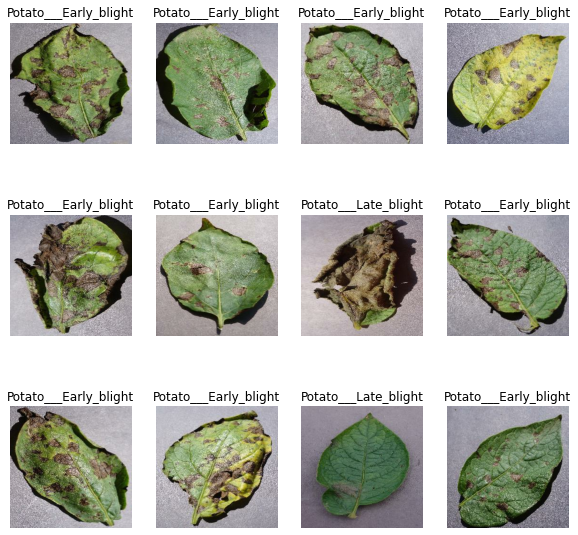

In [7]:
#printing the images for test purpose
plt.figure(figsize=(10,10))#increasing the dimensions of the images
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# Function to Split Dataset
# Dataset should be bifurcated into 3 subsets, namely:

# Training: Dataset to be used while training
# Validation: Dataset to be tested against while training
# Test: Dataset to be tested against after we trained a model

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(val_ds)

6

In [12]:
len(test_ds)

8

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Building the Model
# Creating a Layer for Resizing and Normalization
# Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

# You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

In [14]:
#preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])


In [ ]:
# Model Architecture
# We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_2 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [27]:
# Compiling the Model
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 213s 4s/step - loss: 0.8789 - accuracy: 0.5584 - val_loss: 0.6663 - val_accuracy: 0.7413
Epoch 2/50
54/54 [==============================] - 192s 4s/step - loss: 0.5563 - accuracy: 0.7627 - val_loss: 0.3934 - val_accuracy: 0.8403
Epoch 3/50
54/54 [==============================] - 185s 3s/step - loss: 0.4016 - accuracy: 0.8293 - val_loss: 0.2766 - val_accuracy: 0.8860
Epoch 4/50
54/54 [==============================] - 191s 4s/step - loss: 0.2758 - accuracy: 0.8848 - val_loss: 0.2969 - val_accuracy: 0.8721
Epoch 5/50
54/54 [==============================] - 189s 3s/step - loss: 0.2627 - accuracy: 0.9039 - val_loss: 0.4977 - val_accuracy: 0.7957
Epoch 6/50
54/54 [==============================] - 183s 3s/step - loss: 0.2069 - accuracy: 0.9149 - val_loss: 0.2005 - val_accuracy: 0.9207
Epoch 7/50
54/54 [==============================] - 182s 3s/step - loss: 0.1777 - accuracy: 0.9306 - val_loss: 0.2010 - val_accuracy: 0.9144
Epoch 8/50
54

In [31]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 36s 667ms/step - loss: 0.2792 - accuracy: 0.9196


In [32]:
scores

[0.2791990637779236, 0.9195601940155029]

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.5584490895271301,
 0.7627314925193787,
 0.8292824029922485,
 0.8848379850387573,
 0.9039351940155029,
 0.9149305820465088,
 0.9305555820465088,
 0.9444444179534912,
 0.9502314925193787,
 0.9635416865348816,
 0.9693287014961243,
 0.9745370149612427,
 0.9739583134651184,
 0.9542824029922485,
 0.9623842835426331,
 0.9733796119689941,
 0.9791666865348816,
 0.9826388955116272,
 0.9895833134651184,
 0.9861111044883728,
 0.9837962985038757,
 0.9837962985038757,
 0.9832175970077515,
 0.9837962985038757,
 0.9803240895271301,
 0.9890046119689941,
 0.9849537014961243,
 0.9803240895271301,
 0.9675925970077515,
 0.9872685074806213,
 0.9832175970077515,
 0.9930555820465088,
 0.9913194179534912,
 0.9895833134651184,
 0.9890046119689941,
 0.9872685074806213,
 0.9733796119689941,
 0.9890046119689941,
 0.9861111044883728,
 0.9890046119689941,
 0.9918981194496155,
 0.9907407164573669,
 0.9895833134651184,
 0.9936342835426331,
 0.9936342835426331,
 0.9918981194496155,
 0.9907407164573669,
 0.9797453880

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

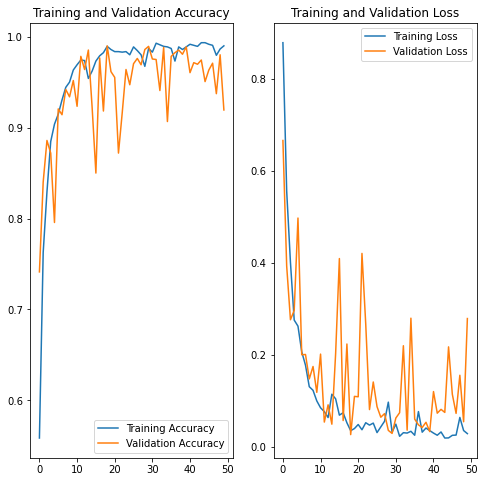

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Run prediction on a sample image

first image to predict
first image's actual label: Potato___Late_blight
predicted label: Potato___Late_blight


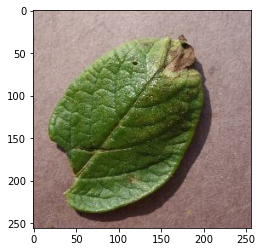

In [57]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [58]:
#Write a function for inference

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

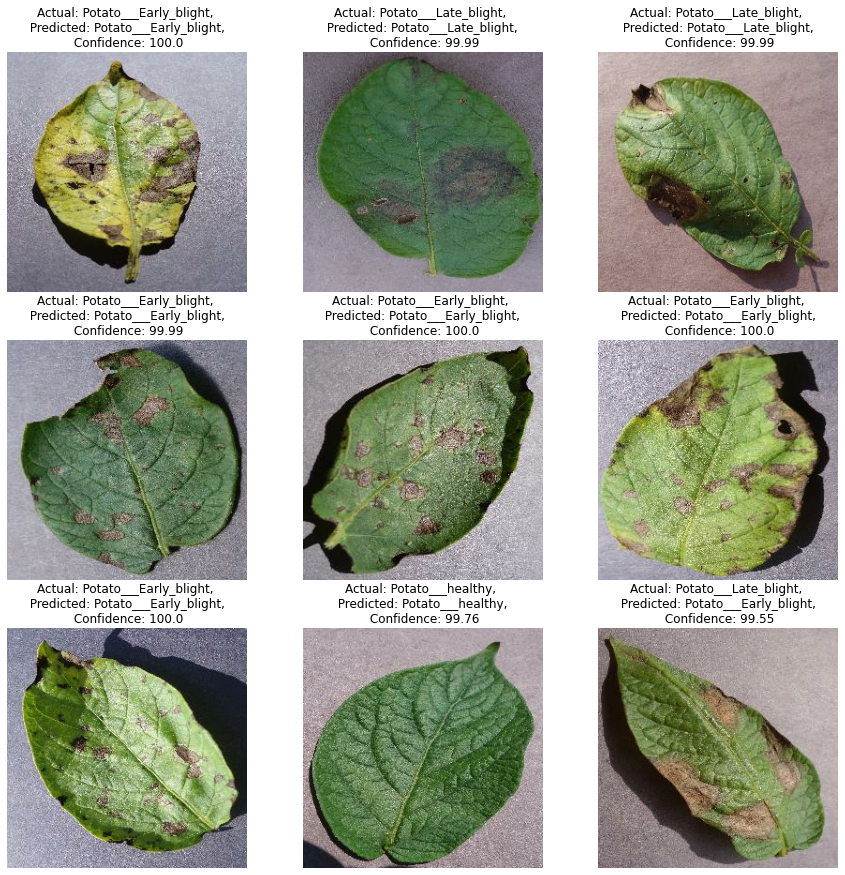

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        plt.axis('off')

In [74]:
import os
max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
